In [191]:
import numpy as np
import pandas as pd
import pdb
from ipynb.fs.full.Game import *
import random # import randrange

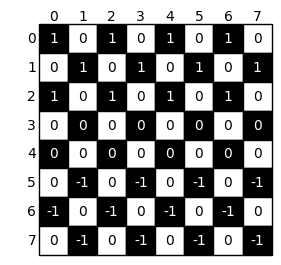

In [2]:
board_1 = np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1])
state = [board_1, -1]
visualize(state)

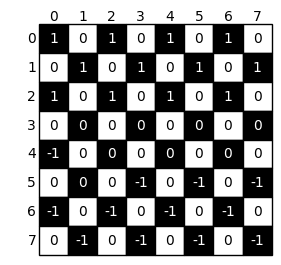

In [3]:
visualize([nextState([board_1, -1, (20,16)], (20,16), 0)[0], -1])

In [5]:
action_space = [(0,4),#0
 (1,4),#1
 (1,5),#2
 (2,5),#3
 (2,6),#4
 (3,6),#5
 (3,7),#6
 (4,0),#7
 (4,1),#8
 (4,8),#9
 (4,9),#10
 (5,1),#11
 (5,2),#12
 (5,9),#13
 (5,10),#14
 (6,2),#15
 (6,3),#16
 (6,10),#17
 (6,11),#18
 (7,3),#19
 (7,11),#20
 (8,4),#21
 (8,12),#22
 (9,4),#23
 (9,5),#24
 (9,12),#25
 (9,13),#26
 (10,5),#27
 (10,6),#28
 (10,13),#29
 (10,14),#30
 (11,6),#31
 (11,7),#32
 (11,14),#33
 (11,15),#34
 (12,8),#35
 (12,9),#36
 (12,16),#37
 (12,17),#38
 (13,9),#39
 (13,10),#40
 (13,17),#41
 (13,18),#42
 (14,10),#43
 (14,11),#44
 (14,18),#45
 (14,19),#46
 (15,11),#47
 (15,19),#48
 (16, 12),#49
 (16, 20),#50
 (17, 12),#51
 (17, 13),#52
 (17, 20),#53
 (17, 21),#54
 (18, 13),#55
 (18, 14),#56
 (18, 21),#57
 (18, 22),#58
 (19, 14),#59
 (19, 15),#60
 (19, 22),#61
 (19, 23),#62
 (20, 16),#63
 (20, 17),#64
 (20, 24),#65
 (20, 25),#66
 (21, 17),#67
 (21, 18),#68
 (21, 25),#69
 (21, 26),#70
 (22, 18),#71
 (22, 19),#72
 (22, 26),#73
 (22, 27),#74
 (23, 19),#75
 (23, 27),#76
 (24, 20),#77
 (24, 28),#78
 (25, 20),#79
 (25, 21),#80
 (25, 28),#81
 (25, 29),#82
 (26, 21),#83
 (26, 22),#84
 (26, 29),#85
 (26, 30),#86
 (27, 22),#87
 (27, 23),#88
 (27, 30),#89
 (27, 31),#90
 (28, 24),#91
 (28, 25),#92
 (29, 25),#93
 (29, 26),#94
 (30, 26),#95
 (30, 27),#96
 (31, 27)]#97

# Q table

## game over

In [325]:
def game_over(board, agent, action_space, turns_without_cap):
    '''function checks whether game is over and returns tuple bool and winner (as an int)'''
    res = []
    if turns_without_cap == 80: 
        return 0
    for move in action_space:
        res.append(referee(action_space, [board, agent, move])[0])
    
    #no move is legal then game is over and the other agent wins    
    #pdb.set_trace()
    if not any(res):
        winner = - agent
        return winner
    else:    
        return None

In [198]:
board_1 = np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1])

#df with each move in the action space as col and ind_board as index - for every row neg value if the move is illegal
Q_white = pd.DataFrame(data = 0, index=[0], columns=action_space)
Q_black = pd.DataFrame(data = 0, index=[0], columns=action_space)

#np array of boards seens by each agent - retrievable with ind_board e.g. white_boards[ind_board]
white_boards = {0:np.array([board_1])}
black_boards = {}

#dict of moves for the game played, ind_board is the key and the move select for that given idx board is the value
white_moves = {} #ind_board as key and move as value
black_moves = {}

#nested dict first key is ind_board, inside that another dict with caps as key and Q_value as value
#e.g. {ind_board: {(first_multi_cap: Q_value, second_multi_cap: Q_value)}}
white_mult_caps_dict = {}
black_mult_caps_dict = {}

In [421]:
def initialise_board(initial_board, agent, Q_color, color_boards):
    '''Function that creates ind_board (that will be assigned to it in the Q table) for a given board. '''
    #case where board is not already in white_boards/black_board
    if sum([(initial_board == board).all() for board in color_boards.values()]) == 0:
        #initialise board in Q table
        ind_board = len(color_boards)
        #color_boards = np.append(color_boards, [initial_board], axis=0)
        color_boards[ind_board] = initial_board
        #add board index as row in Q
        Q_color.loc[ind_board] = 0

    #case where board was already seen
    else: 
        #retrieve ind_board for the already seen board
        ind_board = [key for key, value in color_boards.items() if (initial_board == value).all()][0]
    return ind_board, color_boards

In [374]:
def find_move(initial_board, agent, ind_board, Q_color, epsilon, color_mult_caps_dict = {}):
    '''finds the best legal move consider all cases where there is more than 1 legal - if move is not legal updates
    Qtable with -100'''
    is_legal = False
    explotation_idx = random.uniform(0, 1)
    while is_legal == False:
        if explotation_idx < epsilon:
            #choose randomly
            my_move = random.choice((Q_color.loc[ind_board, Q_color.loc[ind_board] > -1000]).index)
            full_state = [initial_board, agent, my_move]
            is_legal, caps = referee(action_space, full_state)

        else:#explotation
            #choose move by selecting the max col in row representing current board
            moves = list(Q_color.loc[ind_board, Q_color.loc[ind_board] == max(Q_color.loc[ind_board])].index)
            #if more than one optimal move
            if len(moves)>1: 
                #random choice ##TO BE DISCUSSED  ###seems okay (Fede 11/01/2025)
                my_move = random.choice(moves)#[random.randrange(len(moves))]
            else:
                my_move = moves[0]
        
            full_state = [initial_board, agent, my_move]
            is_legal, caps = referee(action_space, full_state)
        if not is_legal:
            #set move to -100 (i.e. illegal)
            Q_color[my_move][ind_board] += -1000
        
    #NOW my_move is legal
    #if you can eat
    #pdb.set_trace()
    if caps != 0:
        # RARE: if there are multiple double caps with the same first cap
        if len(caps) > 1 and len(caps[0]) > 1 and len(set(item[0] for item in caps if len(item) > 0)) < len(caps):
            #add board to nested dict of situation with multiple caps for white
            if ind_board not in color_mult_caps_dict.keys():
                color_mult_caps_dict[ind_board] = {}
                for mov in caps:
                    color_mult_caps_dict[ind_board][str(mov)] = 0
            #pdb.set_trace()
            #take the key that has the highest value
            my_move = max(color_mult_caps_dict[ind_board], key=color_mult_caps_dict[ind_board].get)
            #color_mult_caps_dict[ind_board][str(my_move)] -=1
            #filter the best moves from caps 
            my_move = [mov for mov in caps if str(mov) == my_move][0]
            #returns list e.g. [(17, 13), (10, 5)]
       
        #case when there're more than one multiple caps but with different first cap
        elif len(caps) > 1 and len(caps[0]) > 1 and len(set(item[0] for item in caps if len(item) > 0)) == len(caps):
            first_cap_moves = [multi_cap[0] for multi_cap in caps]
            values = Q_color.loc[ind_board, first_cap_moves]
            best_first_cap = values.idxmax()
            # Find the corresponding multi_cap in caps
            my_move = next(multi_cap for multi_cap in caps if multi_cap[0] == best_first_cap)
            #returns list e.g. [(18, 14), (11, 6)]
            
        #case when there's one multiple cap
        elif len(caps) < 2 and len(caps[0]) > 1:
            my_move = caps[0]
            #returns list e.g. [(18, 14), (11, 6)]

       #case when there's one single cap
        elif len(caps) == 1 and len(caps[0]) == 1:
            return caps[0] #returns list e.g. [(13, 17)]
    return my_move #it's a list if it's a capture otherwise a tuple

In [435]:
isinstance(['my_move'], list)

True

In [456]:
def update_board(initial_board, agent, ind_board, my_move, color_boards, color_moves, turns_without_cap = 0):
    '''return new board and updates the number of turns without cap'''
    #updates board after move
    #if there is a cap
    if isinstance(my_move, list):
        #turns_without_cap = 0
        for cap in my_move:
            initial_board, turns_without_cap = nextState([initial_board, agent, cap], cap, turns_without_cap)
    #normal move - e.g. no captures 
    else:
        #pdb.set_trace()
        initial_board, turns_without_cap = nextState([initial_board, agent, my_move], my_move, turns_without_cap)
    visualize([initial_board, agent])

    #add to history of moves in this game
    if ind_board in color_moves: # Check if ind_board exists in color_moves
        #check if this position has already appeared twice - if so end the game
        if len(color_moves[ind_board]) >= 3: 
            turns_without_cap = 100
            return initial_board, turns_without_cap
        color_moves[ind_board].append(my_move)
    else:  # If it doesn't exist, set my_move as the value
        if isinstance(my_move, tuple): 
            color_moves[ind_board] = [my_move]
        else:
            color_moves[ind_board] = my_move
    return initial_board, turns_without_cap, color_boards, color_moves

In [359]:
def play_game(initial_board, agent, Q_white, Q_black, white_boards, black_boards, white_moves, black_moves, epsilon, turns_without_cap = 0):
    #pdb.set_trace()
    if agent == -1:
        print("its whites' turn")
        input()
        ind_board, white_boards = initialise_board(initial_board, agent, Q_white, white_boards)
        move = find_move(initial_board, agent, ind_board, Q_white, epsilon, white_mult_caps_dict)
        new_board, turns_without_cap, white_boards, white_moves = update_board(
            initial_board, agent, ind_board, move, white_boards, white_moves, turns_without_cap)
        agent = 1
        #visualize([new_board, agent])
        winner = game_over(new_board, agent, action_space, turns_without_cap)
        if winner is None:
            return play_game(new_board, agent, Q_white, Q_black, white_boards, black_boards, white_moves, black_moves, turns_without_cap)
        else:
            if winner > 0:
                print("Black wins the game!")
            elif winner < 0:
                print("White wins the game!")
            else:
                "It's a tie"    
        return winner

    elif agent == 1:
        print("its black's turn")
        input()
        ind_board, black_boards_boards = initialise_board(initial_board, agent, Q_black, black_boards)
        move = find_move(initial_board, agent, ind_board, Q_black, epsilon, black_mult_caps_dict)
        new_board, turns_without_cap, black_boards, black_moves = update_board(
            initial_board, agent, ind_board, move, black_boards, black_moves, turns_without_cap)
        agent = -1
        #visualize([new_board, agent])
        winner = game_over(new_board, agent, action_space, turns_without_cap)
        #pdb.set_trace()
        if winner is None:
            return play_game(new_board, agent, Q_white, Q_black, white_boards, black_boards, white_moves, black_moves, turns_without_cap)
        else:
            if winner > 0:
                print("Black wins the game!")
            elif winner < 0:
                print("White wins the game!")
            else:
                "It's a tie"
        return winner#, Q_white, Q_black, white_boards, black_boards, white_moves, black_moves
            

In [477]:
def training(winner, Q_white, Q_black, white_boards, black_boards, white_moves, black_moves, learning_rate, discount_factor):
    # Update for white
    #pdb.set_trace()
    white_idx_boards = list(white_moves.keys())
    white_list_moves = list(white_moves.values())
    for move_number in reversed(range(len(white_idx_boards))):
        ind_board = white_idx_boards[move_number]
        move = white_list_moves[move_number]
        reward = 1 if winner == -1 else -1  # Reward for white (1 if white won, -1 if lost)
        next_ind_board = white_idx_boards[move_number + 1] if move_number != len(white_idx_boards) - 1 else None
        max_future_q = Q_white.loc[next_ind_board, :].max() if next_ind_board else 0
        if len(move) == 1:
            Q_white.loc[ind_board, move] += learning_rate * (reward + discount_factor * max_future_q - Q_white.loc[ind_board, move])
        else: 
            Q_white.loc[ind_board, [move[0]]] += learning_rate * (reward + discount_factor * max_future_q - Q_white.loc[ind_board, [move[0]]])
            #if ind_board in color_mult_caps_dict.keys():

    
    # Update for black
    black_idx_boards = list(black_moves.keys())
    black_list_moves = list(black_moves.values())
    for move_number in reversed(range(len(black_idx_boards))):
        ind_board = black_idx_boards[move_number]
        move = black_list_moves[move_number]
        reward = 1 if winner == 1 else -1  # Reward for black (1 if black won, -1 if lost)
        next_ind_board = black_idx_boards[move_number + 1] if move_number != len(black_idx_boards) - 1 else None
        max_future_q = Q_black.loc[next_ind_board, :].max() if next_ind_board else 0
        if len(move) == 1:
            Q_black.loc[ind_board, move] += learning_rate * (reward + discount_factor * max_future_q - Q_black.loc[ind_board, move])
        else:
            Q_black.loc[ind_board, [move[0]]] += learning_rate * (reward + discount_factor * max_future_q - Q_black.loc[ind_board, [move[0]]])
            

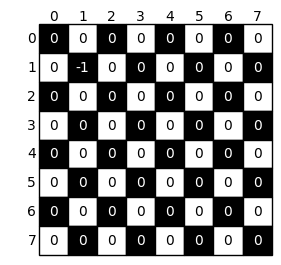

(array([ 0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 0,
 {0: array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
          1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])},
 {0: [(20, 17), (13, 9)]})

In [474]:
ind_board, white_boards = initialise_board(bb, -1, Q_white, white_boards)
my_move = find_move(bb, -1, ind_board, Q_white, 0)
update_board(bb, -1, ind_board, my_move, white_boards, white_moves)

In [475]:
white_moves

{0: [(20, 17), (13, 9)]}

In [481]:
board_1 = np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1])

#df with each move in the action space as col and ind_board as index - for every row neg value if the move is illegal
Q_white = pd.DataFrame(data = 0, index=[0], columns=action_space)
Q_black = pd.DataFrame(data = 0, index=[0], columns=action_space)

#np array of boards seens by each agent - retrievable with ind_board e.g. white_boards[ind_board]
white_boards = {}
black_boards = {}

#dict of moves for the game played, ind_board is the key and the move select for that given idx board is the value
white_moves = {} #ind_board as key and move as value
black_moves = {}

#nested dict first key is ind_board, inside that another dict with caps as key and Q_value as value
#e.g. {ind_board: {(first_multi_cap: Q_value, second_multi_cap: Q_value)}}
white_mult_caps_dict = {}
black_mult_caps_dict = {}

its whites' turn


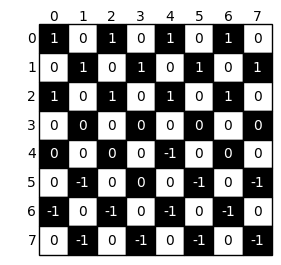

its black's turn


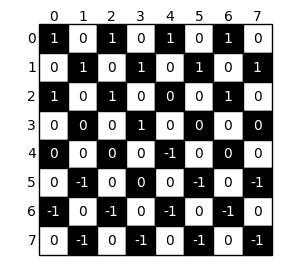

its whites' turn


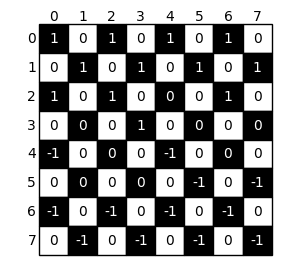

its black's turn


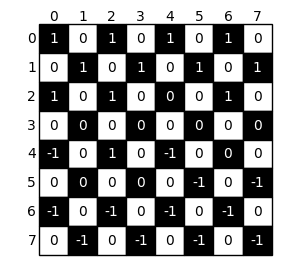

its whites' turn


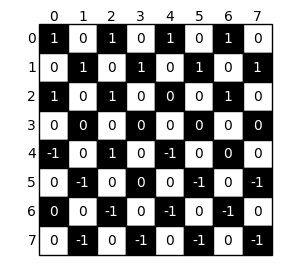

its black's turn


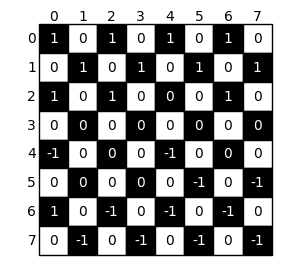

its whites' turn


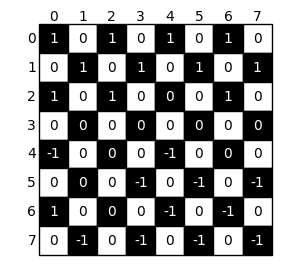

its black's turn


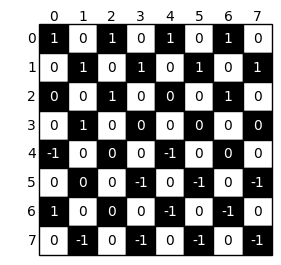

its whites' turn


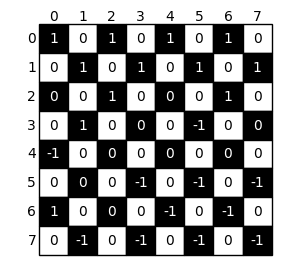

its black's turn


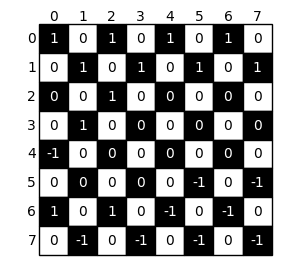

its whites' turn


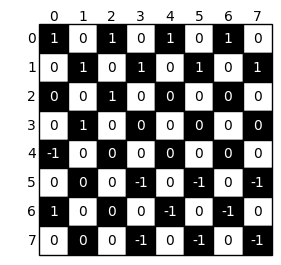

its black's turn


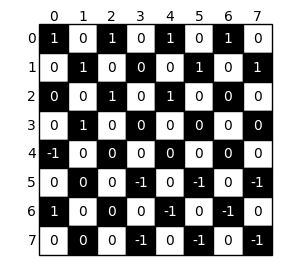

its whites' turn


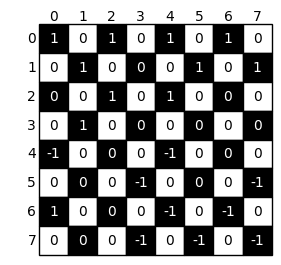

its black's turn


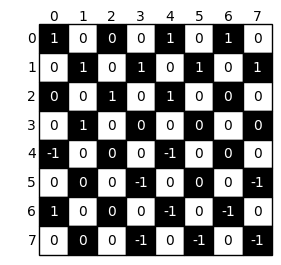

its whites' turn


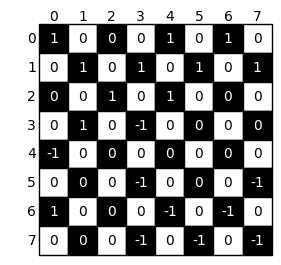

its black's turn


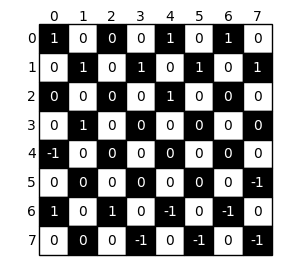

its whites' turn


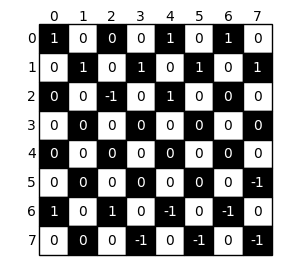

its black's turn


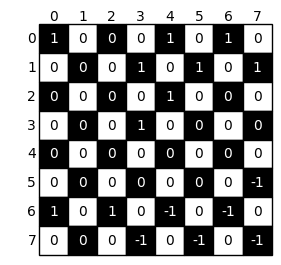

its whites' turn


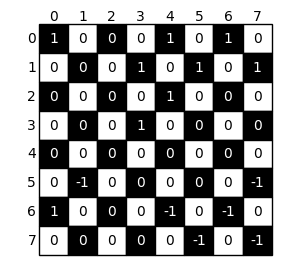

its black's turn


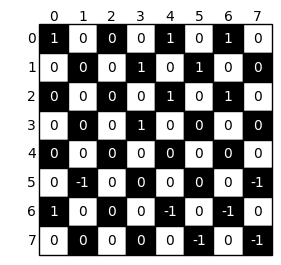

its whites' turn


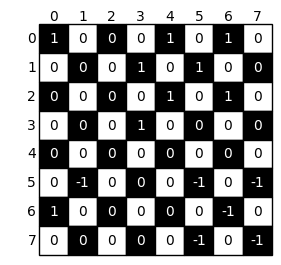

its black's turn


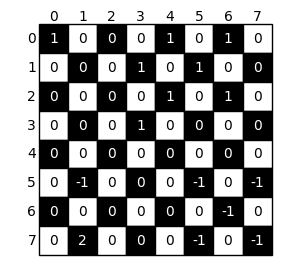

its whites' turn


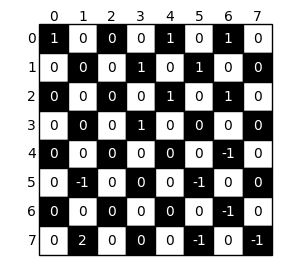

its black's turn


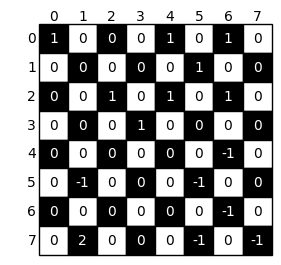

its whites' turn


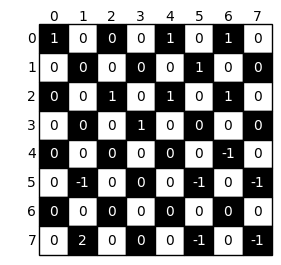

its black's turn


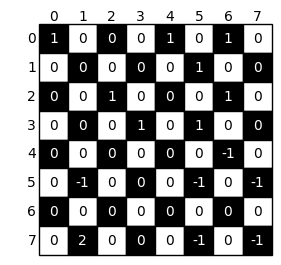

its whites' turn


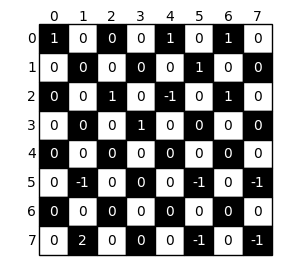

its black's turn


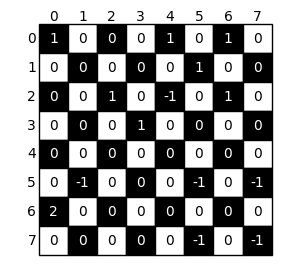

its whites' turn


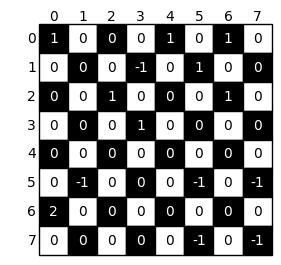

its black's turn


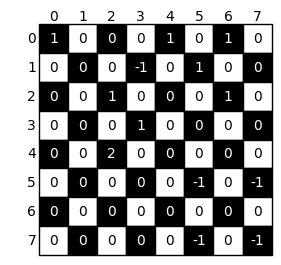

its whites' turn


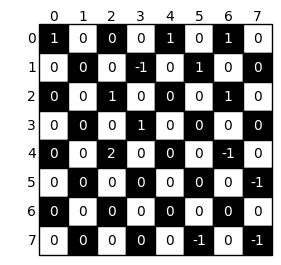

its black's turn


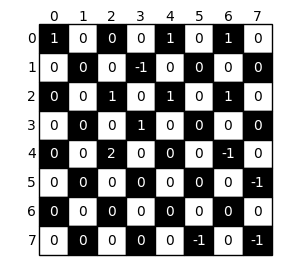

its whites' turn


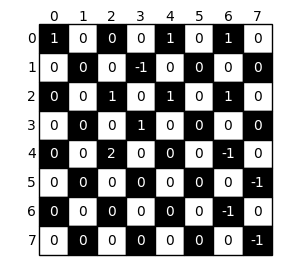

its black's turn


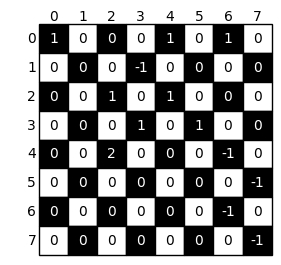

its whites' turn


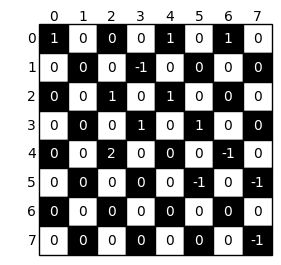

its black's turn


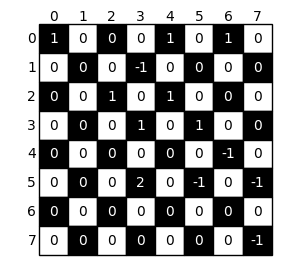

its whites' turn


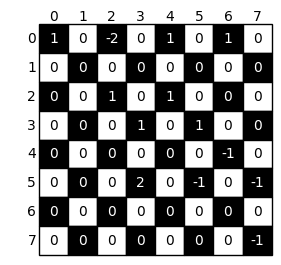

its black's turn


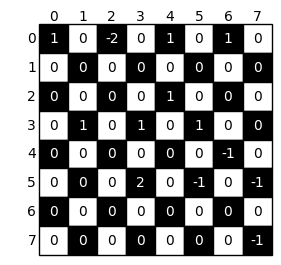

its whites' turn


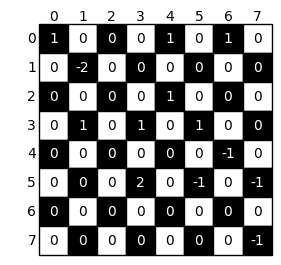

its black's turn


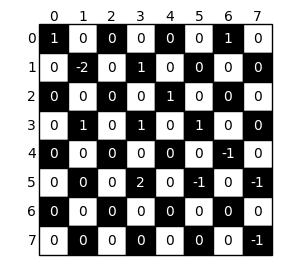

its whites' turn


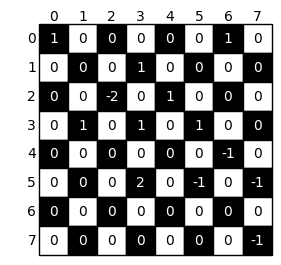

its black's turn


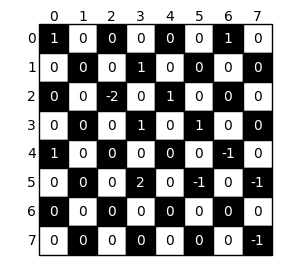

its whites' turn


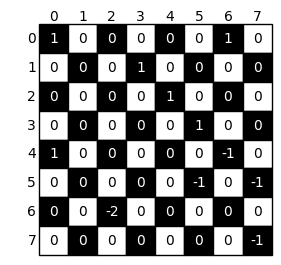

its black's turn


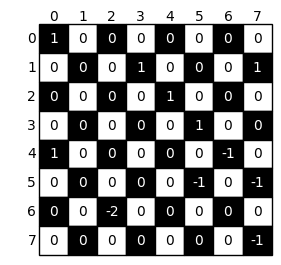

its whites' turn


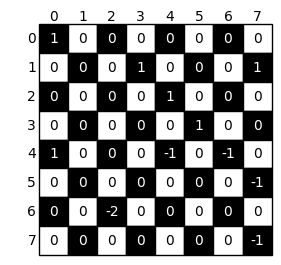

its black's turn


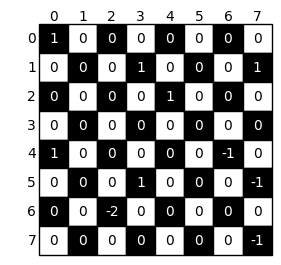

its whites' turn


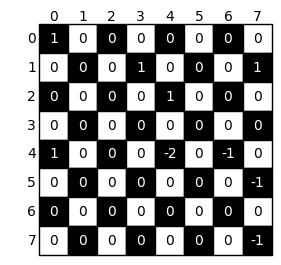

its black's turn


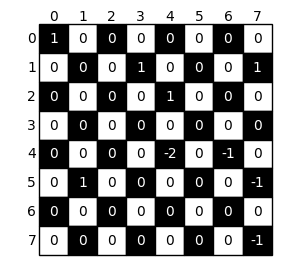

its whites' turn


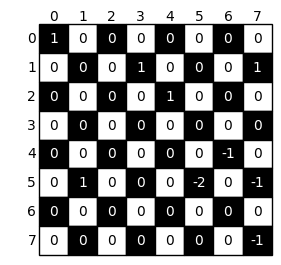

its black's turn


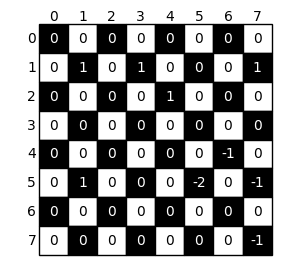

its whites' turn


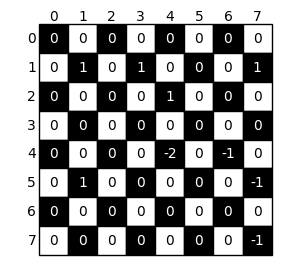

its black's turn


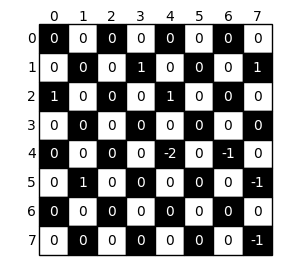

its whites' turn


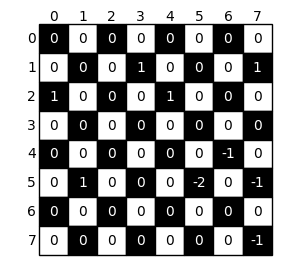

its black's turn


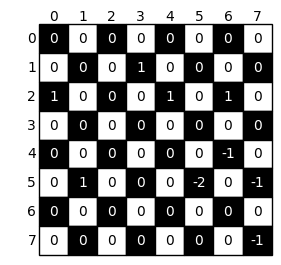

its whites' turn


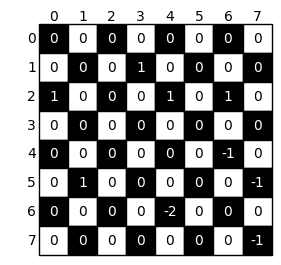

its black's turn


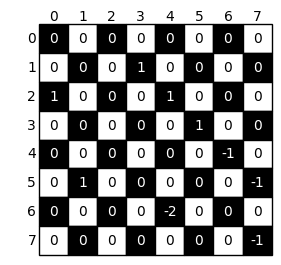

its whites' turn


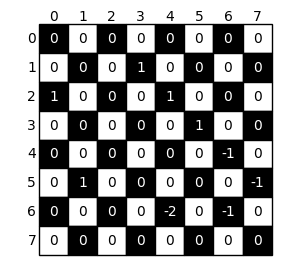

its black's turn


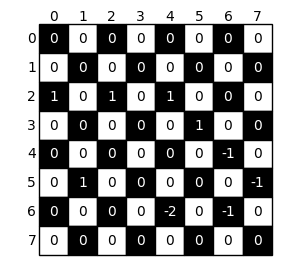

its whites' turn


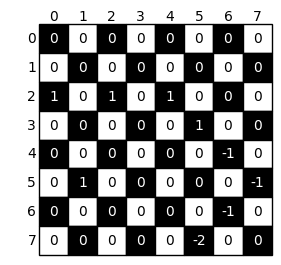

its black's turn


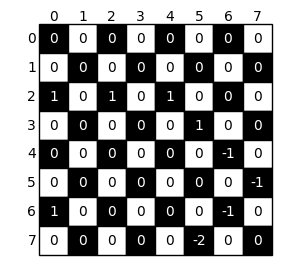

its whites' turn


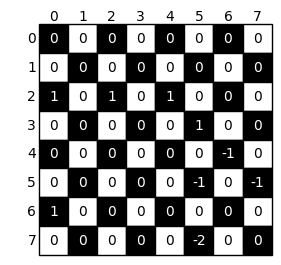

its black's turn


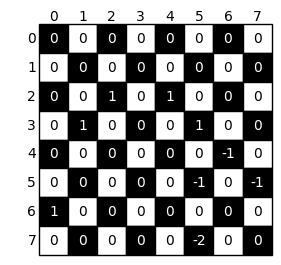

its whites' turn


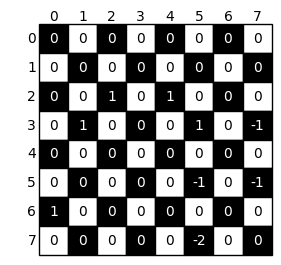

its black's turn


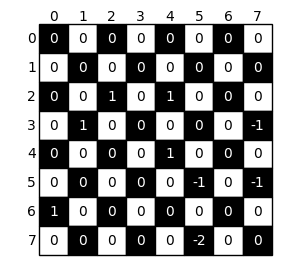

its whites' turn


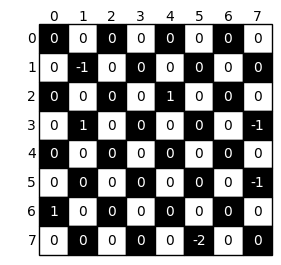

its black's turn


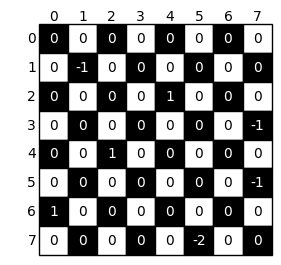

its whites' turn


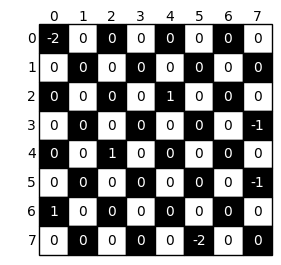

its black's turn


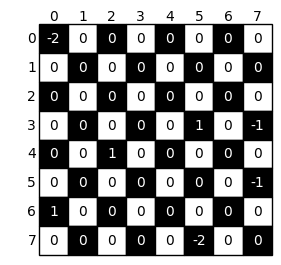

its whites' turn


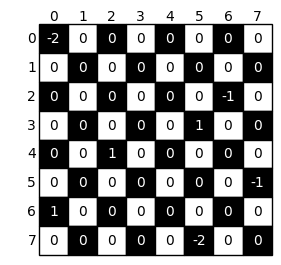

its black's turn


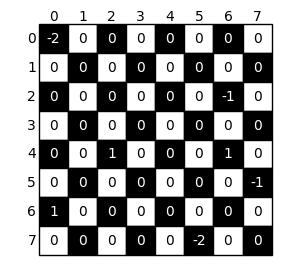

its whites' turn


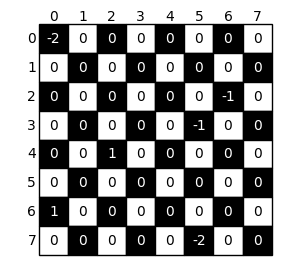

its black's turn


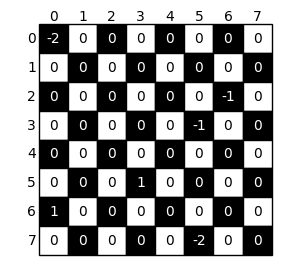

its whites' turn


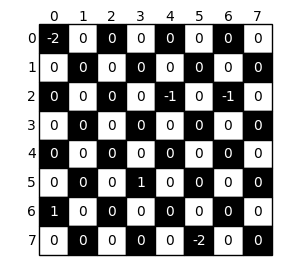

its black's turn


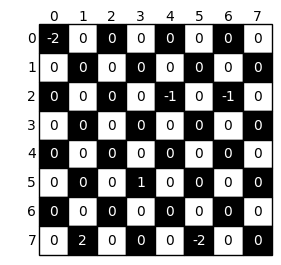

its whites' turn


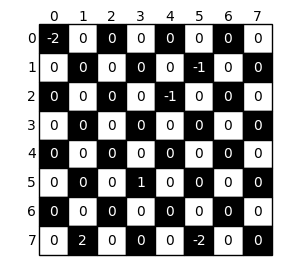

its black's turn


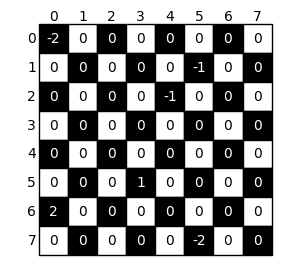

its whites' turn


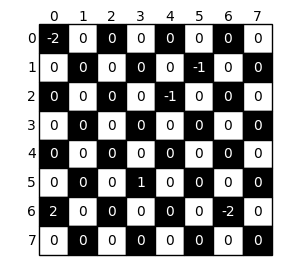

its black's turn


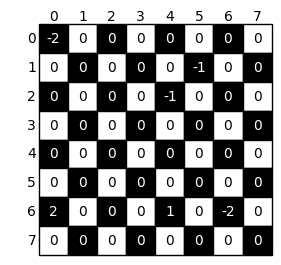

its whites' turn


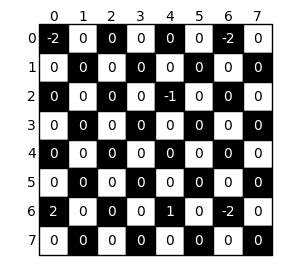

its black's turn


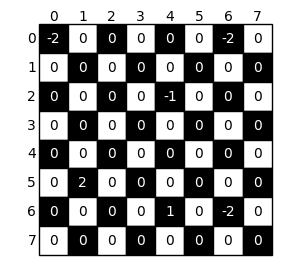

its whites' turn


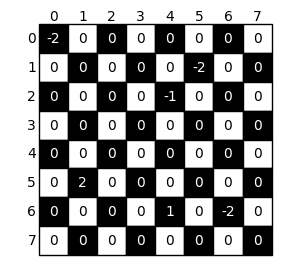

its black's turn


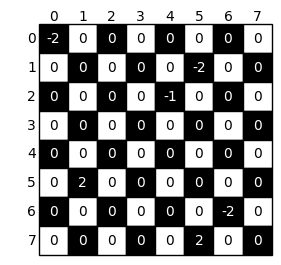

its whites' turn


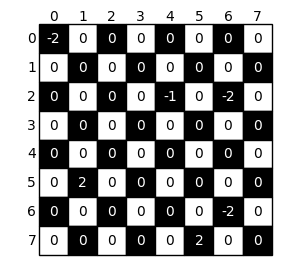

its black's turn


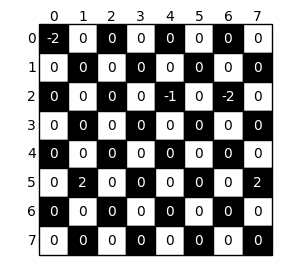

its whites' turn


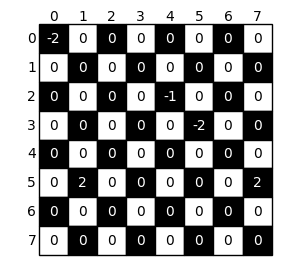

its black's turn


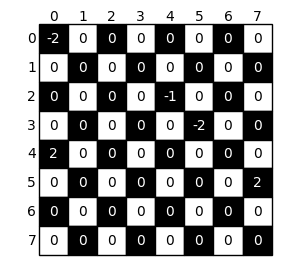

its whites' turn


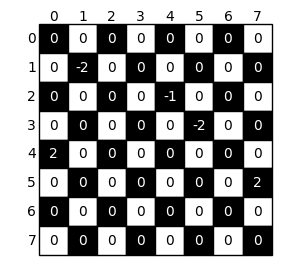

its black's turn


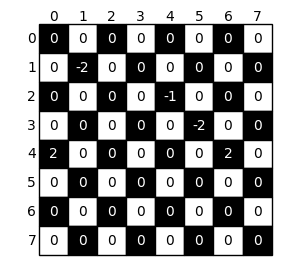

its whites' turn


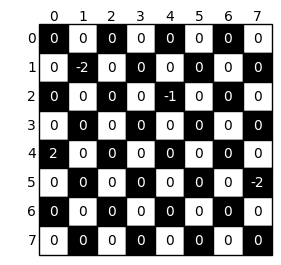

its black's turn


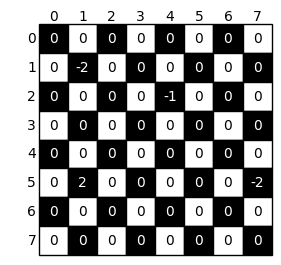

its whites' turn


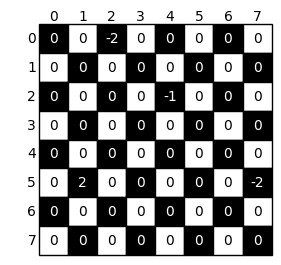

its black's turn


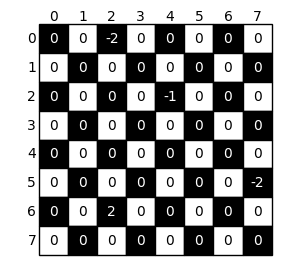

its whites' turn


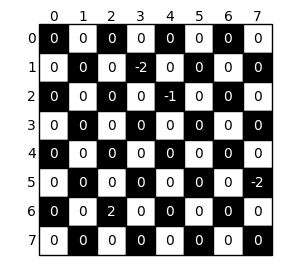

its black's turn


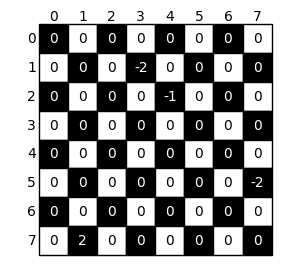

its whites' turn


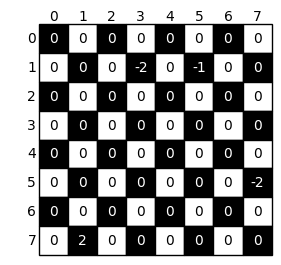

its black's turn


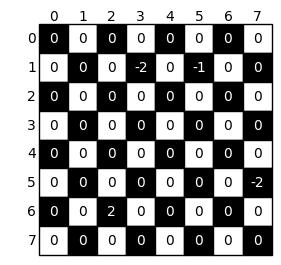

its whites' turn


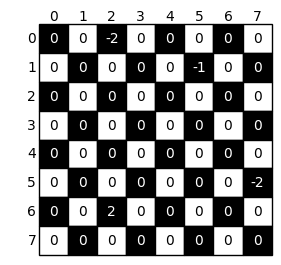

its black's turn


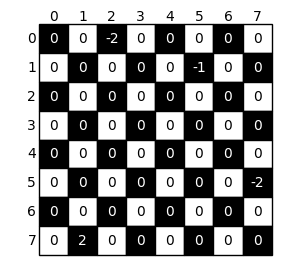

its whites' turn


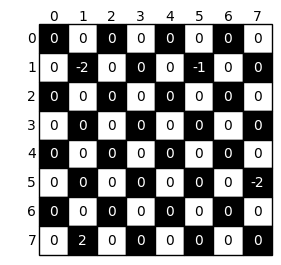

its black's turn


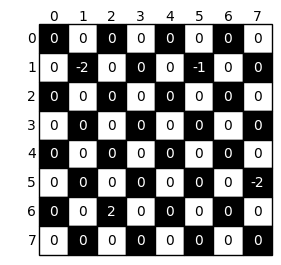

its whites' turn


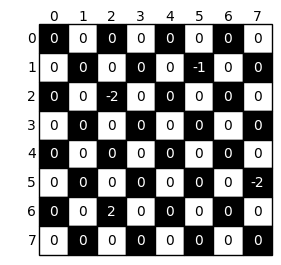

its black's turn


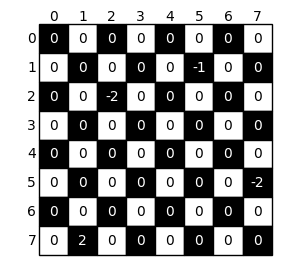

its whites' turn


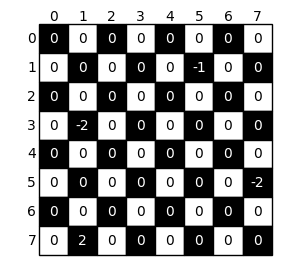

its black's turn


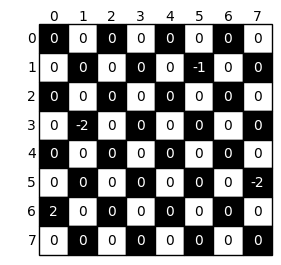

its whites' turn


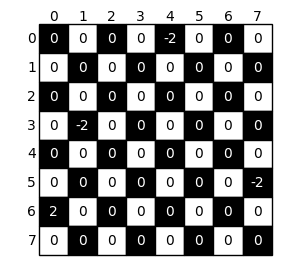

its black's turn


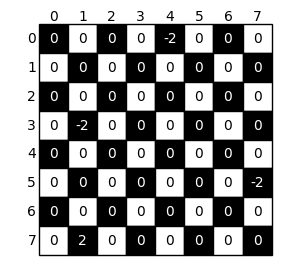

its whites' turn


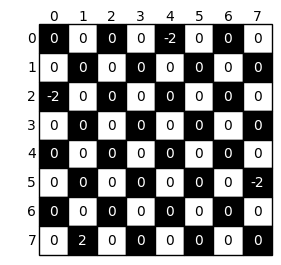

its black's turn


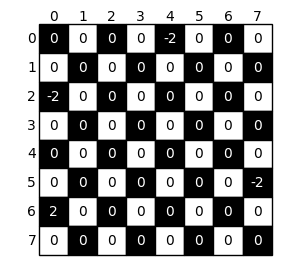

its whites' turn


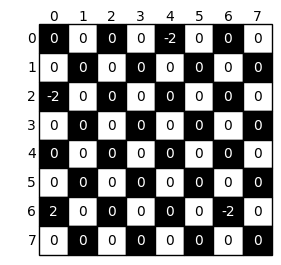

its black's turn


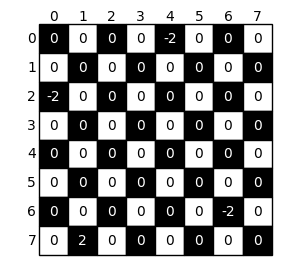

its whites' turn


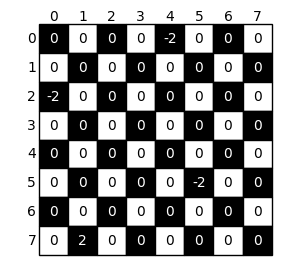

its black's turn


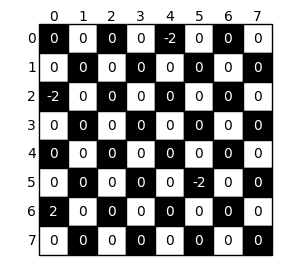

its whites' turn


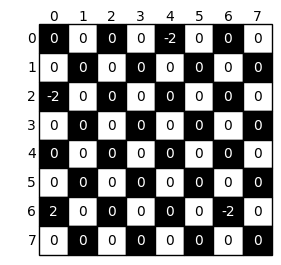

its black's turn


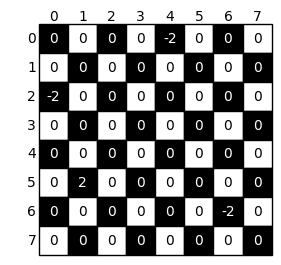

its whites' turn


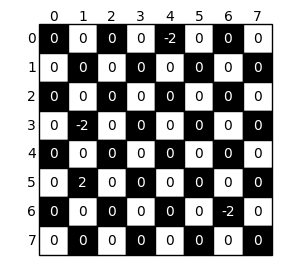

its black's turn


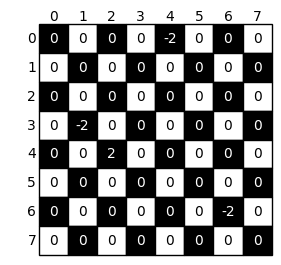

its whites' turn


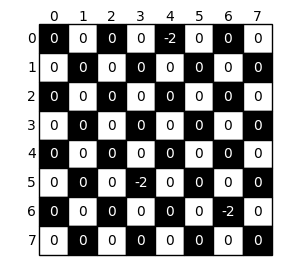

White wins the game!


In [482]:
white_moves = {}
black_moves = {}
winner = play_game(board_1, -1, Q_white, Q_black, white_boards, black_boards, white_moves, black_moves, 0.9)


In [484]:
white_mult_caps_dict

{32: {'[(22, 18), (13, 9)]': 0, '[(22, 18), (13, 10)]': 0}}

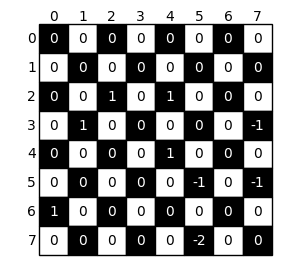

In [485]:
visualize([white_boards[32], -1])

In [483]:
white_moves

{0: [(21, 18)],
 1: [(20, 16)],
 2: [(24, 20)],
 3: [(25, 21)],
 4: [(18, 14)],
 5: [(28, 25)],
 6: [(22, 18)],
 7: [(18, 13)],
 8: [(16, 12)],
 9: [(29, 25)],
 10: [(26, 22)],
 11: [(23, 19)],
 12: [(27, 23)],
 13: [(19, 14)],
 14: [(10, 5)],
 15: [(22, 19)],
 16: [(30, 27)],
 17: [(27, 22)],
 18: [(5, 1)],
 19: [(1, 4)],
 20: [(4, 9)],
 21: [(9, 13), (18, 21)],
 22: [(22, 18)],
 23: [(25, 21)],
 24: [(18, 22)],
 25: [(22, 18)],
 26: [(18, 22)],
 27: [(22, 26)],
 28: [(31, 27)],
 29: [(26, 30)],
 30: [(27, 22)],
 31: [(19, 15)],
 32: [(22, 18), (13, 9)],
 33: [(4, 0)],
 34: [(15, 11)],
 35: [(23, 19)],
 36: [(14, 10)],
 37: [(11, 6)],
 38: [(30, 27)],
 39: [(6, 3)],
 40: [(3, 6)],
 41: [(6, 11)],
 42: [(11, 14)],
 43: [(0, 4)],
 44: [(14, 19)],
 45: [(4, 1)],
 46: [(1, 5)],
 47: [(10, 6)],
 48: [(5, 1)],
 49: [(1, 4)],
 50: [(4, 9)],
 51: [(9, 12)],
 52: [(6, 2)],
 53: [(12, 8)],
 54: [(23, 27)],
 55: [(27, 22)],
 56: [(22, 27)],
 57: [(8, 12)],
 58: [(12, 17)]}

In [396]:
(d.keys())

dict_keys([0, 1, 2])

In [470]:
Q_white.loc[0,[(0, 4)]]

(0, 4)   -1000.0
Name: 0, dtype: float64

In [476]:
training(winner, Q_white, Q_black, white_boards, black_boards, white_moves, black_moves, learning_rate = 0.1, discount_factor= 0.9)


> /var/folders/g3/ytphggnx1yqbm2c08220yr6c0000gn/T/ipykernel_58903/1541580448.py(13)training()
     11         max_future_q = Q_white.loc[next_ind_board, :].max() if next_ind_board else 0
     12         pdb.set_trace()
---> 13         Q_white.loc[ind_board, move] += learning_rate * (reward + discount_factor * max_future_q - Q_white.loc[ind_board, move])
     14 
     15     # Update for black



ipdb>  move


[(20, 17), (13, 9)]


ipdb>  len(move)


2


ipdb>  quit


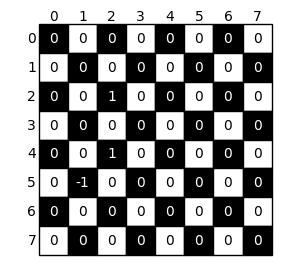

In [472]:
bb = np.array([ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,])

bb[20] = -1
bb[17] = 1
bb[9] = 1

visualize([bb, 1])

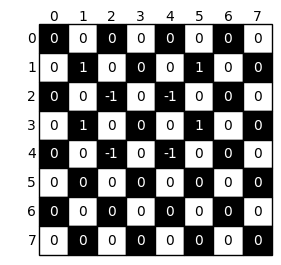

In [200]:
bb = np.array([ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,])

bb[4] = 1
bb[6] = 1
bb[9] = -1
bb[10] = -1
bb[12] = 1
bb[14] = 1
bb[17] = -1
bb[18] = -1
visualize([bb, -1])

# OLD

In [29]:
def Q_table_update(Q_table, color_moves, color_mult_caps_dict, agent):
    '''Update the Q table ONLY for the winner'''
    #for every board index and move
    for ind, moves in color_moves.items():
        #if move is not multiple caps update Q_table with positive reward
        #pdb.set_trace()
        if type(moves) == tuple:
            Q_table[moves][ind] += 0.5

        #if multiple caps enter the nested dict  #WRONG only enter when multi caps were possible
        else:
            if ind in color_mult_caps_dict.keys():
                if str(moves) in color_mult_caps_dict[ind].keys():
                    color_mult_caps_dict[ind][str(moves)] += 0.5
                else:
                    color_mult_caps_dict[ind] = {str(moves): 0.5}

            else:
                my_move = moves[0]
                Q_table[my_move][ind] += 0.5
                    
                   
                        
    #reset history for new game MAYBE NOT NECESSARY
    color_moves = {}
    return Q_table, color_mult_caps_dict

left off here, write case where move is not tuple and decide whether Q_table_update is of any use!! 

In [106]:
def bell_eq(Q_color, color_moves, lr, reward, discount_factor):
    '''TO BE FINISHED'''
    #for every board index and move
    for move_number, ind in enumerate(color_moves):
        move = color_moves[ind]
        if type(move) == tuple:
            if move_number < len(color_moves)-1:
                next_move_val = Q_color[color_moves[ind+1]][ind+1]
            else:
                next_move_val = 1
            
            old_value = Q_color[move][ind]
            Q_color[move][ind] = (1-lr)* old_value + lr*(reward + discount_factor * next_move_val)
    
        #else:
            
            
            
    return Q_color

## Baseline training (working)

In [30]:
def training_Q(initial_board, agent, Q_white, Q_black, white_boards, black_boards, white_mult_caps_dict, 
            black_mult_caps_dict, white_hist = {}, black_hist = {}, game_is_over = False, turns_without_cap = 0):
    '''function that starts a game and then update the Q table for the wiiner'''
    while game_is_over == False:
        if agent == -1:
            ind_board, white_boards = initialise_board(initial_board, agent, Q_white, white_boards)
            my_move = find_move(initial_board, agent, ind_board, Q_white, white_mult_caps_dict)
            initial_board, turns_without_cap = update_board(initial_board, agent, ind_board, my_move, white_hist)
            agent = 1
            game_is_over, winner = game_over(initial_board, agent, action_space, turns_without_cap)
            if game_is_over == True:
                Q_white, white_mult_caps_dict = Q_table_update(Q_white, white_hist, white_mult_caps_dict, -1)
                #Q_black, black_mult_caps_dict = Q_table_update(Q_black, black_hist, black_mult_caps_dict, 1, False)
                return 'and the winner is ' , winner, white_boards

            #return new_board, turns_without_cap
        
        elif agent == 1:
            ind_board, black_boards = initialise_board(initial_board, agent, Q_black, black_boards)
            #pdb.set_trace()
            my_move = find_move(initial_board, agent, ind_board, Q_black, black_mult_caps_dict)
            initial_board, turns_without_cap = update_board(initial_board, agent, ind_board, my_move, black_hist)
            agent = -1
            game_is_over, winner = game_over(initial_board, agent, action_space, turns_without_cap)
            if game_is_over == True:
                Q_black, black_mult_caps_dict = Q_table_update(Q_black, black_hist, black_mult_caps_dict, 1)
                #Q_white, white_mult_caps_dict = Q_table_update(Q_white, white_hist, white_mult_caps_dict, -1, False)
                return 'and the winner is ' , winner,black_boards
    


    white_hist = {}
    black_hist = {}
    
    return initial_board

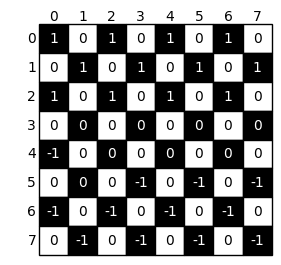

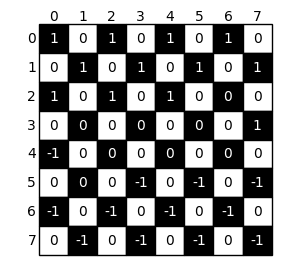

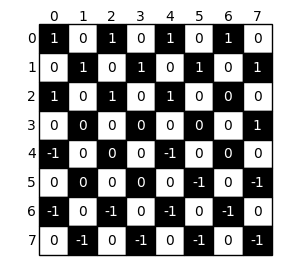

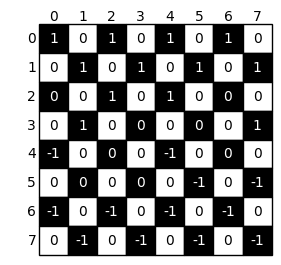

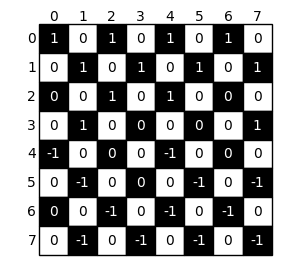

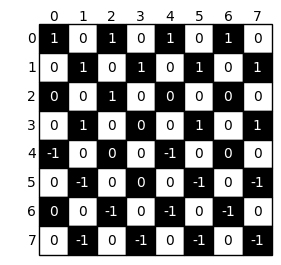

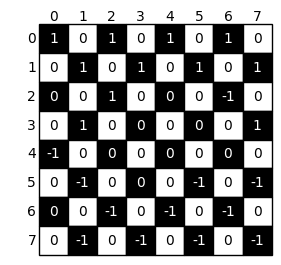

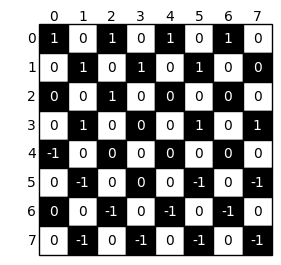

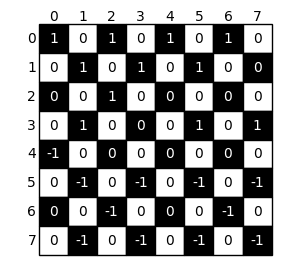

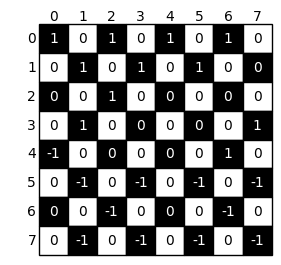

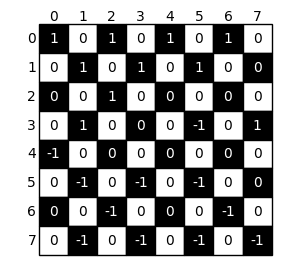

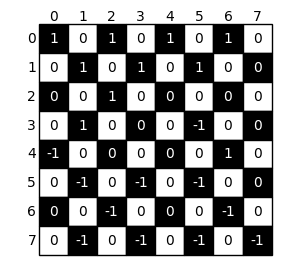

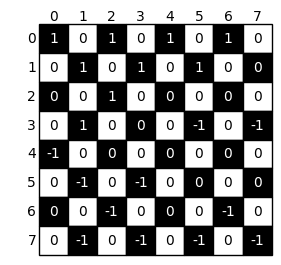

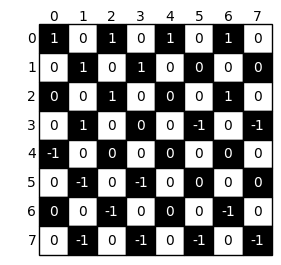

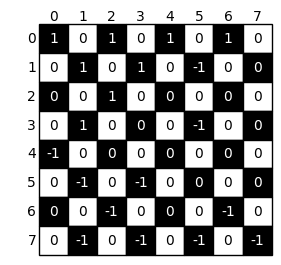

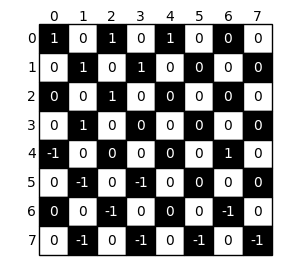

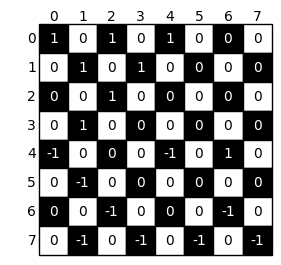

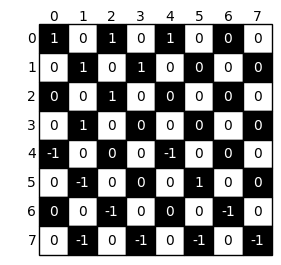

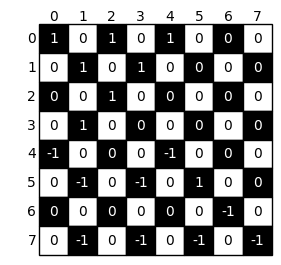

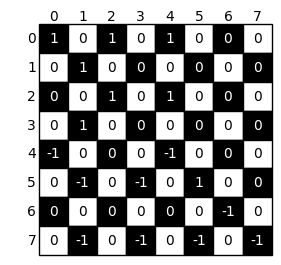

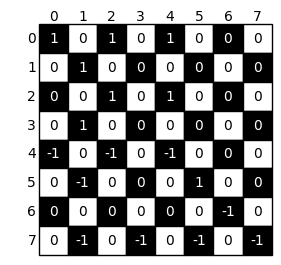

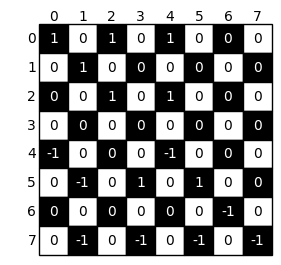

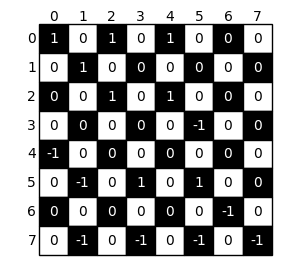

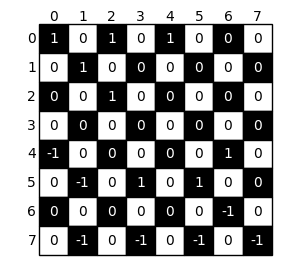

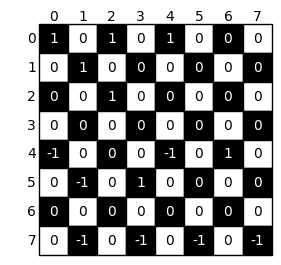

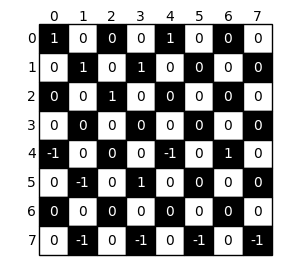

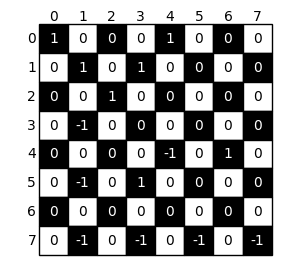

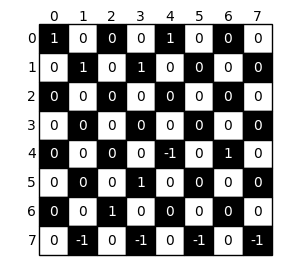

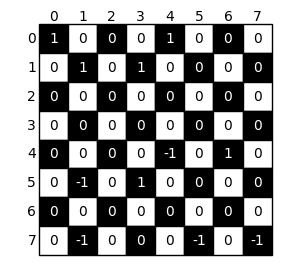

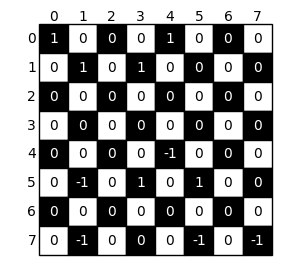

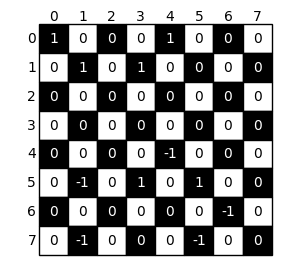

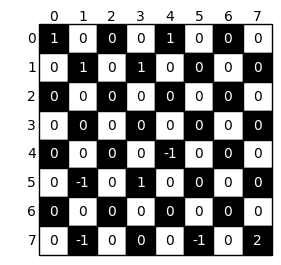

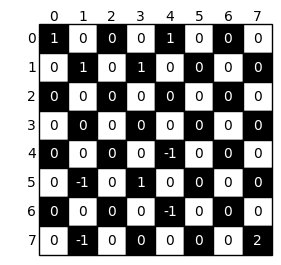

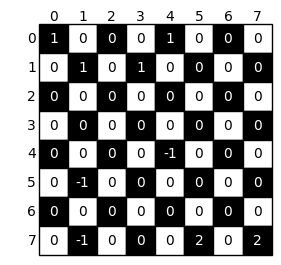

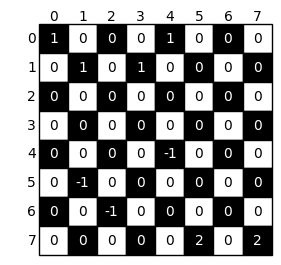

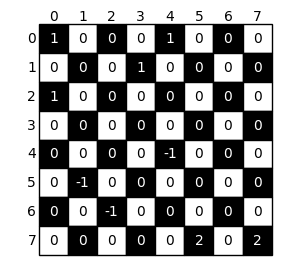

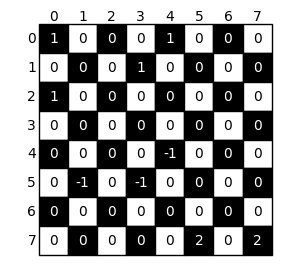

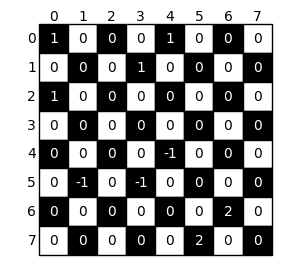

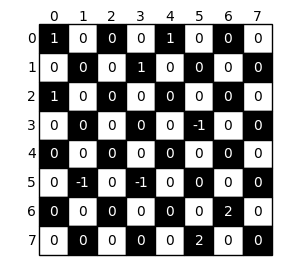

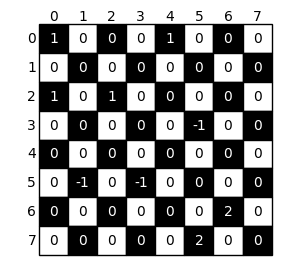

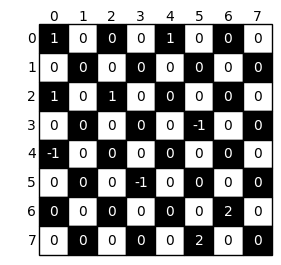

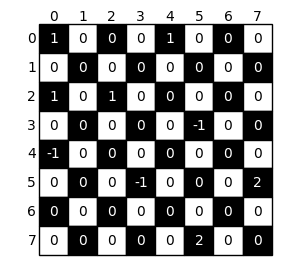

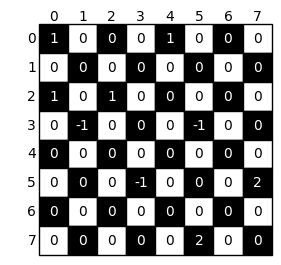

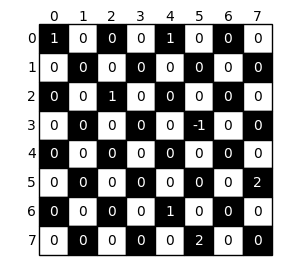

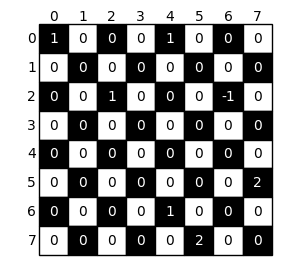

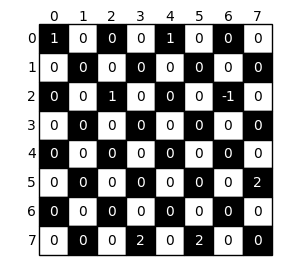

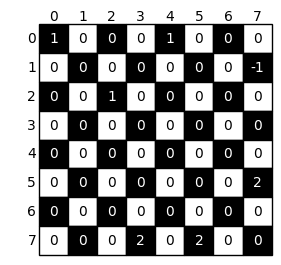

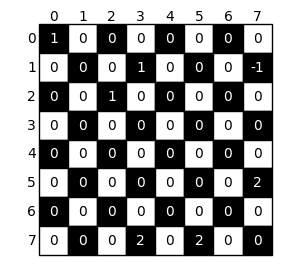

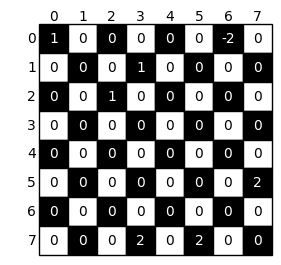

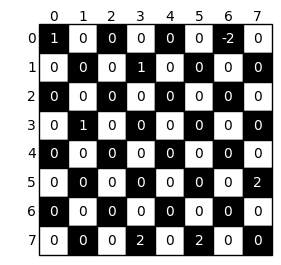

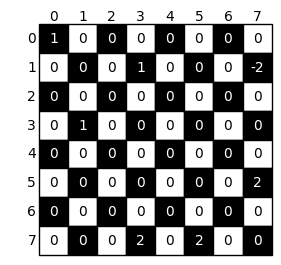

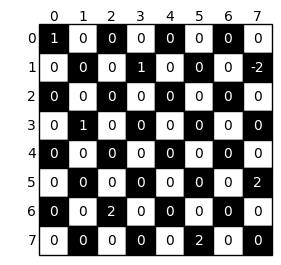

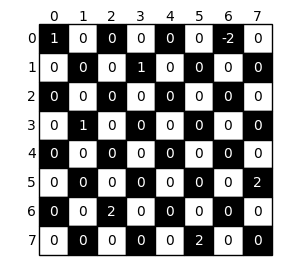

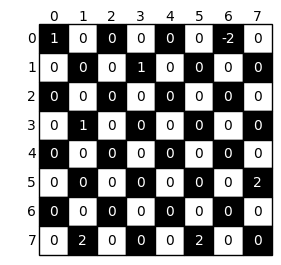

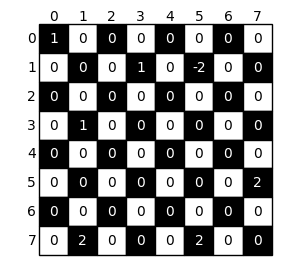

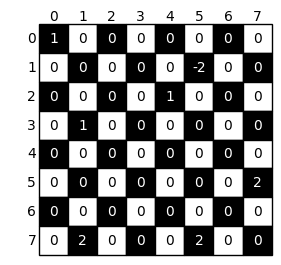

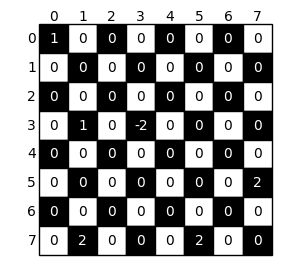

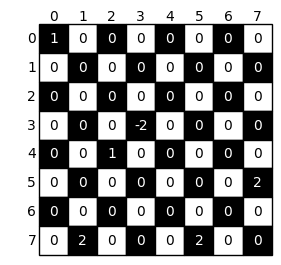

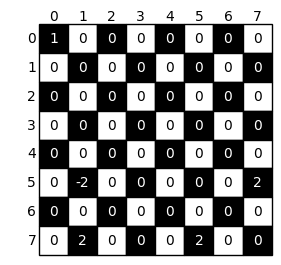

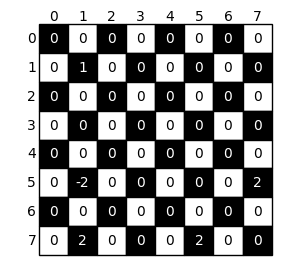

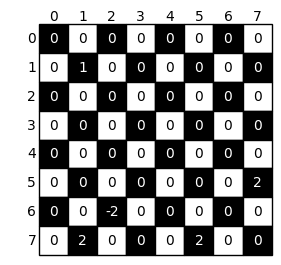

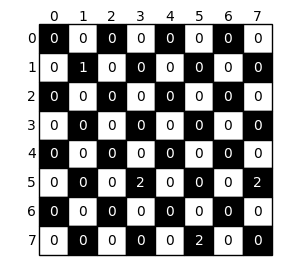

/var/folders/g3/ytphggnx1yqbm2c08220yr6c0000gn/T/ipykernel_47556/3787776384.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Q_table[moves][ind] += 0.5
/var/folders/g3/ytphggnx1yqbm2c08220yr6c0000gn/T/ipykernel_47556/3787776384.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Q_table[my_move][ind] += 0.5


In [33]:
#STORING value after running training_Q!!!!
a,b, black_boards = training_Q(board_1, -1, Q_white, Q_black, white_boards, black_boards, white_mult_caps_dict, 
            black_mult_caps_dict, white_hist, black_hist)

The training above works

In [49]:
black_hist

{1: (11, 15),
 2: (8, 12),
 3: (10, 14),
 4: (7, 11),
 5: (14, 19),
 6: (15, 19),
 7: (6, 11),
 8: [(3, 6), (10, 14)],
 9: (19, 22),
 10: (5, 10),
 11: (12, 17),
 12: (10, 14),
 13: (1, 5),
 14: [(9, 12), (16, 20)],
 15: (19, 22),
 16: (22, 27),
 17: (21, 26),
 18: (4, 8),
 19: (31, 27),
 20: (5, 9),
 21: (27, 23),
 22: [(8, 12), (17, 21)],
 23: (26, 29),
 24: (2, 5),
 25: (9, 12),
 26: (29, 25),
 27: (25, 28),
 28: (5, 10),
 29: (12, 17),
 30: (0, 4),
 31: (28, 25)}

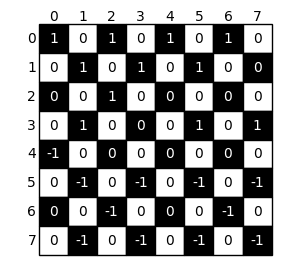

In [45]:
visualize([black_boards[5], 1])

In [30]:
Q_black.loc
Q_black.loc[[1], [(4,9)]]

,"(4, 9)"
1,0


In [32]:
board_1 = np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1])
Q_white = pd.DataFrame(data = 0, index=[0], columns=action_space)
Q_black = pd.DataFrame(data = 0, index=[0], columns=action_space)
white_boards = np.array([board_1])
black_boards = np.array([board_1])
white_mult_caps_dict = {}
black_mult_caps_dict = {}
white_hist = {} #ind_board as key and move as value
black_hist = {}

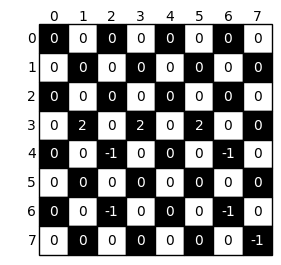

In [66]:
bb = np.array([ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,])

bb[12] = 2
bb[13] = 2
bb[14] = 2
bb[17] = -1
bb[25] = -1
bb[19] = -1
bb[27] = -1
bb[31] = -1

visualize([bb, (0,4)])

In [203]:
#Q_white.loc[[0], [(1,4)]].values()# += -0.5
Q_white[(1,4)][0] #= 0.5

0.0

## Game

In [ ]:
def game(initial_board):
    '''First thing is to create the Q_table and the other necessary tables/dict to keep track of the score. It is 
    also crucial that these are then stored somewhere in order to NOT START AGAIN.
    Within a while loop call the training and the game over functions for white then black, back and forth,
    until the game is over. Then finally update the Q_tables.'''
    
    while game_is_over = False:
        training_white()
        game_is_over = game_over(board, 1, action_space)    
        training_black()
        game_is_over = game_over(board, -1, action_space)
    
    
    

In [ ]:
def training_white(initial_board, agent = -1, white_boards = np.array([board_1]), white_hist = [], 
                   white_mult_caps_dict={}):
    '''Problem with this function is that it relies on Q_white which relies on white_state_dict both defined outside
    the function. In addition there are many table/list that are important to the training purpose. NEED to 
    understand what it will return!
    '''
    if sum([(initial_board == board).all() for board in white_boards]) == 0:
        #initialise board in Q table
        white_boards = np.append(white_boards, [initial_board], axis=0)
        #add board index as row  in Q
        ind_board = white_boards.shape[0] -1 
        Q_white.loc[ind_board] = 0

    #case where board was already seen
    else: 
        #first create list where first true is the idx of the board
        ind_board = [idx for idx, bb in enumerate([(initial_board == b).all() for b in white_boards]) if bb][0]

    is_legal = False
    while is_legal == False:
        #choose move by selecting the max col in row representing current board
        moves = list(Q_white.loc[ind_board, Q_white.loc[ind_board] == max(Q_white.loc[ind_board])].index)
        #if more than one optimal move
        if len(moves)>1: 
            #random choice 
            my_move = moves[random.randrange(len(moves))]
        else:
            my_move = moves

        full_state = [initial_board, agent, my_move]
        is_legal, caps = referee(action_space, full_state)
        if not is_legal:
            #set move to -100 (i.e. illegal)
            Q_white.loc[[ind_board], [my_move]] += -100

    #NOW my_move is legal
    #if you can eat
    if caps != 0:
        # RARE: if there are multiple double caps
        if len(caps[0]) > 1 and len(caps) > 1:
            #add board to nested dict of situation with multiple caps for white
            if ind_board not in white_mult_caps_dict.keys():
                white_mult_caps_dict[ind_board] = {}
                for mov in caps:
                    white_mult_caps_dict[ind_board][str(mov)] = 0
            my_move = max(white_mult_caps_dict[ind_board])
            my_move = [mov for mov in caps if str(mov) == my_move][0]
        
        #case when there's one multiple cap
        elif len(caps[0]) > 1:
            pdb.set_trace()
            my_move = caps[0]
    #update board after move
    #first rare case where there are multiple caps
    if type(my_move) == list:
        for cap in my_move:
            initial_board = nextState([initial_board, agent, cap], cap)
    #all other cases (single cap or simple move)
    else:
        initial_board = nextState([initial_board, agent, my_move], my_move)
    visualize([initial_board, agent])
    #add to history of moves in this game for white
    white_hist.append(my_move)

        
        

# Luigi

In [22]:
numbers = np.arange(1,99,1)

In [23]:
action_dict = dict(zip(numbers,action_space))

In [24]:
action_dict

{1: (0, 4),
 2: (1, 4),
 3: (1, 5),
 4: (2, 5),
 5: (2, 6),
 6: (3, 6),
 7: (3, 7),
 8: (4, 0),
 9: (4, 1),
 10: (4, 8),
 11: (4, 9),
 12: (5, 1),
 13: (5, 2),
 14: (5, 9),
 15: (5, 10),
 16: (6, 2),
 17: (6, 3),
 18: (6, 10),
 19: (6, 11),
 20: (7, 3),
 21: (7, 11),
 22: (8, 4),
 23: (8, 12),
 24: (9, 4),
 25: (9, 5),
 26: (9, 12),
 27: (9, 13),
 28: (10, 5),
 29: (10, 6),
 30: (10, 13),
 31: (10, 14),
 32: (11, 6),
 33: (11, 7),
 34: (11, 14),
 35: (11, 15),
 36: (12, 8),
 37: (12, 9),
 38: (12, 16),
 39: (12, 17),
 40: (13, 9),
 41: (13, 10),
 42: (13, 17),
 43: (13, 18),
 44: (14, 10),
 45: (14, 11),
 46: (14, 18),
 47: (14, 19),
 48: (15, 11),
 49: (15, 19),
 50: (16, 12),
 51: (16, 20),
 52: (17, 12),
 53: (17, 13),
 54: (17, 20),
 55: (17, 21),
 56: (18, 13),
 57: (18, 14),
 58: (18, 21),
 59: (18, 22),
 60: (19, 14),
 61: (19, 15),
 62: (19, 22),
 63: (19, 23),
 64: (20, 16),
 65: (20, 17),
 66: (20, 24),
 67: (20, 25),
 68: (21, 17),
 69: (21, 18),
 70: (21, 25),
 71: (21, 26)

In [25]:
initial_state = [1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]

In [26]:
zeros = np.zeros((1,98))

In [27]:
Q = np.zeros((1,98))

In [28]:
Q

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]])

In [29]:
rows = {'1' : [1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]}

In [30]:
state = (1,1,1,1,1,2,2,3,5,11,2,3,4,5,2,1,4)

In [31]:
def learning(state,new_state,action,lr,reward,gamma):#state and action are int taken from dictionaries
    Q[state,action] = Q[state,action] + lr * (reward + gamma * np.max(Q[new_state,:]) - Q[state,action])

In [32]:
def game_over(board):
    negative_counter = 0
    positive_counter = 0
    #CHANGE
    for x in action_space:
        if referee(x)[0] == True:
            return False
    #PROB delete
    for x in board:
        if x < 0:
            negative_counter += 1
        elif x > 0:
            positive_counter += 1
    if negative_counter > 0 and positive_counter > 0:
        return False
    return True
    

In [33]:
def determine_reward():
    if referee(action_space,full_state)[0] == False:
        return -1
    elif game_over() == True:
        return 1 #don't understand why
    else:
        return 0

In [34]:
def append_dict(state,Q):
    if state not in rows.values():
        rows[f'{len(rows)+1}'] = state
        Q = np.append(Q,zeros,axis = 0)
        return Q
    return Q

In [35]:
Q = append_dict([1,2,3,4,5,6,7,8,9],Q)

In [36]:
rows

{'1': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1],
 '2': [1, 2, 3, 4, 5, 6, 7, 8, 9]}

In [37]:
Q.shape

(2, 98)

In [38]:
rows

{'1': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1],
 '2': [1, 2, 3, 4, 5, 6, 7, 8, 9]}

In [39]:
def get_temporal_difference(state_index,move_index,reward,gamma):
    max_action = np.argmax(Q[state_index])
    max_Q = Q[state_index][max_action]
    current_Q = Q[state_index][move_index]
    return reward + (gamma * (max_Q - current_Q))

# training

In [40]:
lr = 1
gamma = 0.8
reward = 0

In [41]:
full_state = [[0,1,1,1,1],1,(4,10)]

In [42]:
state = full_state[0]

In [43]:
def epsilon_greed(current_board,epsilon):
    state_number = 0
    for number,board_state in rows.items():
        if board == current_board:
            state_number = number
        else:
            append_dict(full_state[0])
    if np.random.random() < epsilon:
        return np.argmax(Q[state_number])
    else:
        return np.random.randint(98)

In [44]:
full_state = []

In [45]:
np.argmax(Q[1])

0

In [46]:
Q[1][19] = 23

In [47]:
def get_move(index):
    return action_space[index]

In [ ]:
for episode in range(1000):
    board = full_state[0]
    state_index = 0
    for number,board_state in rows.items():
        if board == full_state[0]:
            state_index = number
        else:
            append_dict(full_state[0])
            for number,board_state in rows.items():
                if board == full_state[0]:
                    state_index = number
            
    while game_over(board) == False:
        move_index = epsilon_greed(full_state,epsilon)
        move = get_move(move_index)
        legal_boolean = referee(full_state) #referee the move
        if legal_boolean == False:
            reward = -1
            temporal_difference = get_temporal_difference
            Q[state_index][move_index] = Q[state_index][move_index] + lr * temporal_difference
            continue 
        reward = get_reward()
        nextState()
        Q[state_index][move_index] = Q[state_index][move_index] + lr * temporal_difference